<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/gp_kernel_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GP kernel parameter optimization/ inference 

Slightly modified from 

https://tinygp.readthedocs.io/en/latest/tutorials/modeling.html

(We simplify the code by not passing the `yerr` variable to the model, and rename the input `t` (for time) to `x`, to make it more generic.) 

In [1]:
try:
    import tinygp
except ImportError:
    !pip install -q tinygp

try:
    import numpyro
except ImportError:
    !pip uninstall -y jax jaxlib
    !pip install -q numpyro jax jaxlib

try:
    import arviz
except ImportError:
    !pip install arviz

try:
    import flax
except ImportError:
    !pip install -q flax

try:
    import optax
except ImportError:
    !pip install -q optax

from jax.config import config

config.update("jax_enable_x64", True)

Found existing installation: jax 0.2.25
Uninstalling jax-0.2.25:
  Successfully uninstalled jax-0.2.25
Found existing installation: jaxlib 0.1.71+cuda111
Uninstalling jaxlib-0.1.71+cuda111:
  Successfully uninstalled jaxlib-0.1.71+cuda111
     |████████████████████████████████| 264 kB 932 kB/s 
     |████████████████████████████████| 873 kB 11.6 MB/s 
     |████████████████████████████████| 62.2 MB 1.2 MB/s 
     |████████████████████████████████| 207 kB 13.4 MB/s 
     |████████████████████████████████| 126 kB 66.8 MB/s 
     |████████████████████████████████| 65 kB 4.2 MB/s 


# Data


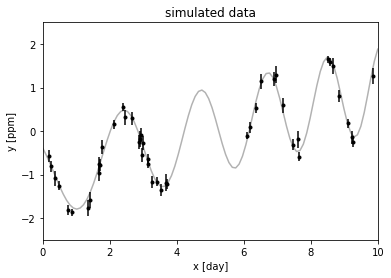

In [15]:
import numpy as np
import matplotlib.pyplot as plt

random = np.random.default_rng(42)

t = np.sort(
    np.append(
        random.uniform(0, 3.8, 28),
        random.uniform(5.5, 10, 18),
    )
)
yerr = random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t - 5) + np.sin(3 * t + 0.1 * (t - 5) ** 2) + yerr * random.normal(size=len(t))

true_t = np.linspace(0, 10, 100)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

x = t
x_test = true_t
y_test = true_y

plt.plot(x_test, y_test, "k", lw=1.5, alpha=0.3)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

plt.savefig("gp-kernel-opt-data.pdf")



# Optimizing hyper-parameters using flax & optax

We  find the maximum (marginal) likelihood hyperparameters for the GP model.


To set up our model, we define a custom `linen.Module`, and optimize it's parameters as follows:

In [16]:
from tinygp import kernels, GaussianProcess

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.linen.initializers import zeros

import optax


class GPModule(nn.Module):
    @nn.compact
    def __call__(self, x, y, t):
        # t = test input locations
        # Returns loss (-log p(y|x)) and predictions p(y|t)
        mean = self.param("mean", zeros, ())
        log_jitter = self.param("log_jitter", zeros, ())

        log_sigma1 = self.param("log_sigma1", zeros, ())
        log_rho1 = self.param("log_rho1", zeros, ())
        log_tau = self.param("log_tau", zeros, ())
        kernel1 = jnp.exp(2 * log_sigma1) * kernels.ExpSquared(jnp.exp(log_tau)) * kernels.Cosine(jnp.exp(log_rho1))

        log_sigma2 = self.param("log_sigma2", zeros, ())
        log_rho2 = self.param("log_rho2", zeros, ())
        kernel2 = jnp.exp(2 * log_sigma2) * kernels.Matern32(jnp.exp(log_rho2))

        kernel = kernel1 + kernel2
        gp = GaussianProcess(kernel, x, diag=jnp.exp(log_jitter), mean=mean)

        loss = -gp.condition(y)
        pred = gp.predict(y, t)

        return loss, pred


def loss(params):
    return model.apply(params, x, y, x_test)[0]

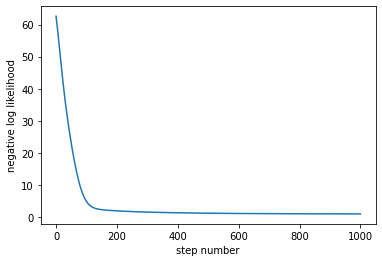

In [17]:
model = GPModule()
params = model.init(jax.random.PRNGKey(0), x, y, x_test)
tx = optax.sgd(learning_rate=3e-3)
opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))

losses = []
for i in range(1001):
    loss_val, grads = loss_grad_fn(params)
    losses.append(loss_val)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

plt.plot(losses)
plt.ylabel("negative log likelihood")
_ = plt.xlabel("step number")

Our `Module` defined above also returns the conditional predictions, that we can compare to the true model:

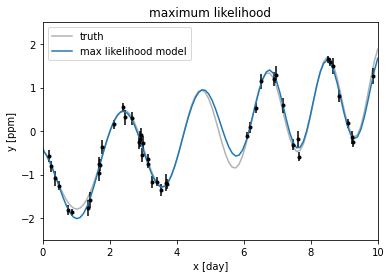

In [18]:
pred = model.apply(params, x, y, x_test)[1]

plt.plot(x_test, y_test, "k", lw=1.5, alpha=0.3, label="truth")
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_test, pred, label="max likelihood model")
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
plt.legend()
_ = plt.title("maximum likelihood")
plt.savefig("gp-kernel-opt-eb.pdf")


# Inferring hyper-parameters using HMC in numpyro

We can compute a posterior over the kernel parameters, and hence the posterior predictive over the mean function, using HMC.

In [25]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

prior_sigma = 5.0


def numpyro_model(x, y, x_test_inputs):
    mean = numpyro.sample("mean", dist.Normal(0.0, prior_sigma))
    jitter = numpyro.sample("jitter", dist.HalfNormal(prior_sigma))

    sigma1 = numpyro.sample("sigma1", dist.HalfNormal(prior_sigma))
    rho1 = numpyro.sample("rho1", dist.HalfNormal(prior_sigma))
    tau = numpyro.sample("tau", dist.HalfNormal(prior_sigma))
    kernel1 = sigma1**2 * kernels.ExpSquared(tau) * kernels.Cosine(rho1)

    sigma2 = numpyro.sample("sigma2", dist.HalfNormal(prior_sigma))
    rho2 = numpyro.sample("rho2", dist.HalfNormal(prior_sigma))
    kernel2 = sigma2**2 * kernels.Matern32(rho2)

    kernel = kernel1 + kernel2
    gp = GaussianProcess(kernel, x, diag=jitter, mean=mean)
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.predict(y, x_test_inputs))


nuts_kernel = NUTS(numpyro_model, dense_mass=True, target_accept_prob=0.9)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=200,
    num_samples=500,
    num_chains=2,
    progress_bar=False,
)
rng_key = jax.random.PRNGKey(34923)

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:280: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains


In [26]:
%%time
mcmc.run(rng_key, x, y, x_test)
samples = mcmc.get_samples()
pred = samples["pred"].block_until_ready()  # Blocking to get timing right

CPU times: user 33.4 s, sys: 17.4 s, total: 50.7 s
Wall time: 29.1 s


In [24]:
print(pred.shape)

(500, 100)


Let's examine the posterior. 
For that task, let's use [`ArviZ`](https://arviz-devs.github.io):

In [27]:
import arviz as az

data = az.from_numpyro(mcmc)
az.summary(data, var_names=[v for v in data.posterior.data_vars if v != "pred"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
jitter,0.017,0.005,0.010,0.026,0.000,0.000,833.0,733.0,1.00
mean,-0.108,1.603,-3.300,2.854,0.097,0.069,356.0,285.0,1.00
rho1,2.463,1.051,1.777,4.150,0.125,0.089,129.0,93.0,1.00
rho2,7.360,3.271,1.826,13.339,0.118,0.084,699.0,598.0,1.00
sigma1,1.114,0.539,0.406,2.021,0.027,0.019,499.0,503.0,1.02
sigma2,1.777,1.118,0.230,3.772,0.058,0.041,338.0,292.0,1.00
tau,2.268,1.116,0.623,4.356,0.084,0.060,136.0,148.0,1.01


And, finally we can plot our posterior inferences of the comditional process, compared to the true model:

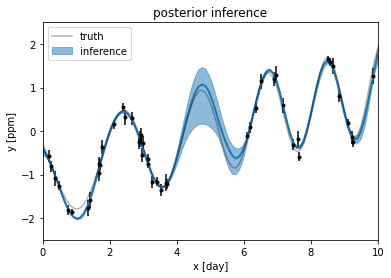

In [28]:
q = np.percentile(pred, [5, 50, 95], axis=0)
plt.fill_between(x_test, q[0], q[2], color="C0", alpha=0.5, label="inference")
plt.plot(x_test, q[1], color="C0", lw=2)
plt.plot(x_test, y_test, "k", lw=1.5, alpha=0.3, label="truth")

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
plt.legend()
_ = plt.title("posterior inference")
plt.savefig("gp-kernel-opt-hmc.pdf")

# Inferring hyper-parameters using HMC in BlackJax

TBD